In [ ]:
%load_ext autoreload
%autoreload 2
%pylab
%matplotlib inline

import os
import sys
import pandas as pd
import pickle
import numpy as np

In [362]:
from batch_sv_system import get_embeds, cosine_sim, compute_plda_score
from utils import key2df, df2dict, compute_eer, get_id2idx
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support

In [523]:
from utils import key2df

embed_dir = "embeddings/voxc2_fbank64_voxc2untied_300f_xvector/"
si_embeds = np.load(embed_dir+"ln_lda_si_embeds.npy")
sv_embeds = np.load(embed_dir+"ln_lda_sv_embeds.npy")
si_keys = pickle.load(open(embed_dir + "/si_keys.pkl", "rb"))
sv_keys = pickle.load(open(embed_dir + "/sv_keys.pkl", "rb"))
sv_id2idx = get_id2idx(sv_keys)
si_df = key2df(si_keys)

In [ ]:
# from utils import get_id2idx
# si_embed_dir = "embeddings/voxc2_fbank64_voxc2untied_300f_xvector/"
# si_embeds = np.load(si_embed_dir + "/si_embeds.npy")
# si_keys = pickle.load(open(si_embed_dir + "/si_keys.pkl", "rb"))
# si_id2idx = get_id2idx(si_keys)
# si_df = key2df(si_keys)

# sv_embed_dir = "embeddings/voxc2_fbank64_voxc2untied_300f_xvector/"
# sv_embeds = np.load(sv_embed_dir + "/sv_embeds.npy")
# sv_keys = pickle.load(open(sv_embed_dir + "/sv_keys.pkl", "rb"))
# sv_id2idx = get_id2idx(sv_keys)
# sv_df = key2df(sv_keys)

# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# si_embed_mean = si_embeds.mean(0)
# centered_si_embeds = si_embeds - si_embed_mean.reshape(1, -1)
# centered_sv_embeds = sv_embeds - si_embed_mean.reshape(1, -1)

# clf = LDA(solver='svd', n_components=200)
# clf.fit(centered_si_embeds, si_df.label)

# lda_si_embeds = clf.transform(centered_si_embeds)
# lda_sv_embeds = clf.transform(centered_sv_embeds)

# # length normalization
# ln_lda_si_embeds = lda_si_embeds * np.sqrt(lda_si_embeds.shape[1]) / \
#                                            np.linalg.norm(lda_si_embeds, axis=1, keepdims=True)
# ln_lda_sv_embeds = lda_sv_embeds * np.sqrt(lda_sv_embeds.shape[1]) / \
#                                            np.linalg.norm(lda_sv_embeds, axis=1, keepdims=True)

# np.save(si_embed_dir+"ln_lda_si_embeds.npy", ln_lda_si_embeds)
# np.save(sv_embed_dir+"ln_lda_sv_embeds.npy", ln_lda_sv_embeds)

In [ ]:
from ioffe_plda.verifier import Verifier
py_plda_model = Verifier()
py_plda_model = Verifier(pickle.load(open("py_plda_model_ln_lda.pkl", "rb")))

# py_plda_model.fit(si_embeds, si_df.label)
# pickle.dump(py_plda_model, open("py_plda_model_ln_lda.pkl", "wb"))

## Dev trial 

In [2456]:
dev_target_trials = pickle.load(open("trials/dev940_eval311/dev_target_trials.pkl", "rb"))

dev_trial_keys = list(dev_target_trials.keys())

dev_target_scores = []
for k, v in tqdm(dev_target_trials.items(), total=len(dev_target_trials)):
    enr_embeds = get_embeds([k], sv_embeds,  sv_id2idx, norm=False)
    test_embeds = get_embeds(v, sv_embeds,  sv_id2idx, norm=False)
    dev_target_scores += py_plda_model.multi_sess(enr_embeds, test_embeds, cov_scaling=False, cov_adapt=False).mean(0).tolist()

pickle.dump(dev_target_scores, open("trials/dev940_eval311/dev_target_score.pkl", "wb"))

## Read trial 

In [489]:
# trials = pickle.load(open("trials/dev940_eval311/hard_enr3xsess_ntar9/small_trials.pkl", "rb"))
trials = pickle.load(open("trials/dev940_eval311/random_enr3xsess_ntar9/small_trials.pkl", "rb"))

In [488]:
trial_keys = [x[0] for x in trials]
trial_keys = pd.DataFrame(trial_keys, columns=['key'])
trial_keys['spk'] = trial_keys.key.apply(lambda x: x[:7])
small_set = trial_keys.groupby("spk", group_keys=False).apply(lambda x: x.sample(n=2))
small_trials = np.array(trials)[small_set.sort_values("spk").index]
pickle.dump(small_trials, open("trials/dev940_eval311/random_enr3xsess_ntar9/small_trials.pkl", "wb"))

## Split trials 

### init, optimal scoreAvg, vectorAvg scores

In [ ]:
init_score_list = []
optimal_score_list = []
scoreAvg_score_list = []
vectorAvg_score_list = []
label_list = []
t_end = len(trials)
t_st = 10
eT = 10
for i, t_i in tqdm(enumerate(range(0, t_end, t_st)), total=t_end//t_st):
    enr_spk, enr_ids, test_trial = trials[t_i]
    test_trial = (np.array(test_trial.id), np.array(test_trial.label))

    adapt_len = 300
    adapt_trial = (test_trial[0][:adapt_len], test_trial[1][:adapt_len])
    test_trial = (test_trial[0][adapt_len:], test_trial[1][adapt_len:])
    label_list.append(test_trial[1])
    
    init_enr_embeds = get_embeds(enr_ids, sv_embeds,  sv_id2idx, norm=False)
    adapt_embeds = get_embeds(adapt_trial[0], sv_embeds, sv_id2idx, norm=False)
    test_embeds = get_embeds(test_trial[0], sv_embeds, sv_id2idx, norm=False)

    # adaptation
    adapt_scores = py_plda_model.score_avg(init_enr_embeds, adapt_embeds)
    adapted_embeds = adapt_embeds[adapt_scores.mean(0) > eT]
    
    # test
    total_enr_embeds = np.concatenate([init_enr_embeds, adapted_embeds])
    optimal_enr_embeds = np.concatenate([init_enr_embeds, adapt_embeds[adapt_trial[1]==1]])
    
    scores = py_plda_model.score_avg(total_enr_embeds, test_embeds)
    init_score_list.append(scores[:3].mean(0))
    optimal_score_list.append(py_plda_model.vector_avg(optimal_enr_embeds, test_embeds).mean(0))
    scoreAvg_score_list.append(scores.mean(0))
    vectorAvg_score_list.append(py_plda_model.vector_avg(total_enr_embeds, test_embeds).mean(0))

In [ ]:
compute_eer(np.concatenate(optimal_score_list), np.concatenate(label_list))
compute_eer(np.concatenate(init_score_list), np.concatenate(label_list))
compute_eer(np.concatenate(scoreAvg_score_list), np.concatenate(label_list))
compute_eer(np.concatenate(vectorAvg_score_list), np.concatenate(label_list));

### multiSess scores 

In [ ]:
multiSess = []
multiSess_scale = []
multiSess_adapt = []
multiSess_scale_adapt = []
multiSess_score_avg = []
label_list = []
t_end = len(trials)
t_st = 10
eT = 5
for i, t_i in tqdm(enumerate(range(0, t_end, t_st)), total=t_end//t_st):
    enr_spk, enr_ids, test_trial = trials[t_i]
    test_trial = (np.array(test_trial.id), np.array(test_trial.label))

    adapt_len = 300
    adapt_trial = (test_trial[0][:adapt_len], test_trial[1][:adapt_len])
    test_trial = (test_trial[0][adapt_len:], test_trial[1][adapt_len:])
    label_list.append(test_trial[1])
    
    init_enr_embeds = get_embeds(enr_ids, sv_embeds,  sv_id2idx, norm=False)
    adapt_embeds = get_embeds(adapt_trial[0], sv_embeds, sv_id2idx, norm=False)
    test_embeds = get_embeds(test_trial[0], sv_embeds, sv_id2idx, norm=False)

    # adaptation
    adapt_scores = py_plda_model.score_avg(init_enr_embeds, adapt_embeds)
    adapted_embeds = adapt_embeds[adapt_scores.mean(0) > eT]
    
    # test
    total_enr_embeds = np.concatenate([init_enr_embeds, adapted_embeds])
    multiSess.append(py_plda_model.multi_sess(total_enr_embeds, test_embeds, 
                                              cov_scaling=False, cov_adapt=False, score_avg=False).mean(0))
    multiSess_scale.append(py_plda_model.multi_sess(total_enr_embeds, test_embeds, 
                                                    cov_scaling=True, cov_adapt=False, score_avg=False).mean(0))
    multiSess_adapt.append(py_plda_model.multi_sess(total_enr_embeds, test_embeds, 
                                                    cov_scaling=False, cov_adapt=True, score_avg=False).mean(0))
    multiSess_scale_adapt.append(py_plda_model.multi_sess(total_enr_embeds, test_embeds, 
                                                    cov_scaling=True, cov_adapt=True, score_avg=False).mean(0))
    multiSess_score_avg.append(py_plda_model.multi_sess(total_enr_embeds, test_embeds, 
                                                    cov_scaling=False, cov_adapt=True, score_avg=True).mean(0))

In [ ]:
# original
compute_eer(np.concatenate(multiSess), np.concatenate(label_list))
# cov_scale
compute_eer(np.concatenate(multiSess_scale), np.concatenate(label_list))
# cov_adapt
compute_eer(np.concatenate(multiSess_adapt), np.concatenate(label_list))
# cov_scale, cov_adapt
compute_eer(np.concatenate(multiSess_scale_adapt), np.concatenate(label_list))
# cov_adapt, score_avg
compute_eer(np.concatenate(multiSess_score_avg), np.concatenate(label_list));

## Batch scores 

In [ ]:
from tqdm import tqdm

batch_vectorAvg = []
batch_multiSess = []
batch_multiSess_scale = []
batch_multiSess_adapt = []
batch_multiSess_scale_adapt = []
batch_labels = []
t_end = len(trials)
t_st = 10
eT = 5
for i, t_i in tqdm(enumerate(range(0, t_end, t_st)), total=t_end//t_st):
    enr_spk, enr_ids, test_trial = trials[t_i]
    enr_embeds = get_embeds(enr_ids, sv_embeds,  sv_id2idx, norm=False)
    test_trial = (np.array(test_trial.id), np.array(test_trial.label))
    test_embeds = get_embeds(test_trial[0], sv_embeds, sv_id2idx, norm=False)
    batch_labels.append(test_trial[1])
    
    adapt_scores = py_plda_model.score_avg(enr_embeds, test_embeds)
    adapt_times = np.append(np.nonzero(adapt_scores.mean(0)>eT)[0], len(test_trial[1]))
    adapted_embeds = test_embeds[adapt_scores.mean(0)>eT] 
    enr_embeds = np.concatenate([enr_embeds, adapted_embeds])
    
    vectorAvg_scores = py_plda_model.vector_avg(enr_embeds, test_embeds)
    multiSess = py_plda_model.multi_sess(enr_embeds, test_embeds, cov_scaling=False, cov_adapt=False)
    multiSess_scale = py_plda_model.multi_sess(enr_embeds, test_embeds, cov_scaling=True, cov_adapt=False)
    multiSess_adapt= py_plda_model.multi_sess(enr_embeds, test_embeds, cov_scaling=False, cov_adapt=True)
    multiSess_scale_adapt = py_plda_model.multi_sess(enr_embeds, test_embeds, cov_scaling=True, cov_adapt=True)
    
    batch_vectorAvg.append(vectorAvg_scores.mean(0))
    batch_multiSess.append(multiSess.mean(0))
    batch_multiSess_scale.append(multiSess_scale.mean(0))
    batch_multiSess_adapt.append(multiSess_adapt.mean(0))
    batch_multiSess_scale_adapt.append(multiSess_scale_adapt.mean(0))

In [ ]:
# vectorAvg
compute_eer(np.concatenate(batch_vectorAvg), np.concatenate(batch_labels))
# original
compute_eer(np.concatenate(batch_multiSess), np.concatenate(batch_labels))
# cov_scale
compute_eer(np.concatenate(batch_multiSess_scale), np.concatenate(batch_labels))
# cov_adapt
compute_eer(np.concatenate(batch_multiSess_adapt), np.concatenate(batch_labels))
# cov_scale, cov_adapt
compute_eer(np.concatenate(batch_multiSess_scale_adapt), np.concatenate(batch_labels))

## Online scores 

In [ ]:
t_i = 2
adapt_len = 1000
enr_spk, enr_ids, test_trial = trials[t_i]
test_trial = (np.array(test_trial.id), np.array(test_trial.label))

adapt_trial = (test_trial[0][:adapt_len], test_trial[1][:adapt_len])
test_trial = (test_trial[0][adapt_len:], test_trial[1][adapt_len:])
label_list.append(test_trial[1])

init_enr_embeds = get_embeds(enr_ids, sv_embeds, sv_id2idx, norm=False)
adapt_embeds = get_embeds(adapt_trial[0], sv_embeds, sv_id2idx, norm=False)
test_embeds = get_embeds(test_trial[0], sv_embeds, sv_id2idx, norm=False)

eT = 5
adapt_scores = py_plda_model.score_avg(init_enr_embeds, adapt_embeds)
adapt_idx = np.nonzero(adapt_scores.mean(0) > eT)[0]
adapt_time = np.sort(np.random.choice(range(len(test_embeds)), size=len(adapt_idx), replace=False))

In [ ]:
adapt_label = adapt_trial[1][adapt_idx]
adapt_confids = adapt_scores.mean(0)[adapt_idx]
np.unique(adapt_label, return_counts=True)

In [ ]:
all_enr_embeds = np.concatenate([init_enr_embeds, adapt_embeds[adapt_idx]])
multiSess = py_plda_model.multi_sess(all_enr_embeds, test_embeds, cov_scaling=True).mean(0)

# offline adapt
compute_eer(multiSess, test_trial[1])

In [ ]:
prev_t = 0
budget = 120
online_multiSess = []
for n, t in tqdm(enumerate(adapt_time.tolist() + [len(test_embeds)]), total=len(adapt_time+1)):
    total_enr_embeds = np.concatenate([init_enr_embeds, adapt_embeds[adapt_idx[adapt_time < t]]])
#     init_enr_score = py_plda_model.score_avg(init_enr_embeds, total_enr_embeds[-1:]).mean(0)
#     new_enr_score = py_plda_model.score_avg(total_enr_embeds[:-1], total_enr_embeds[-1:]).mean(0)
#     print(init_enr_score, new_enr_score, adapt_label[n])
#     print(prev_t, t, total_enr_embeds.shape)
    if len(total_enr_embeds) > budget:
        enr_scores = py_plda_model.multi_sess(init_enr_embeds, total_enr_embeds[3:]).mean(0) 
        total_enr_embeds = np.concatenate([init_enr_embeds, total_enr_embeds[3:][np.argsort(enr_scores)[:budget-3]]])
        test_score = py_plda_model.multi_sess(total_enr_embeds, test_embeds[prev_t:t], cov_scaling=True, cov_adapt=False)
#         test_score = py_plda_model.multi_sess_cluster(total_enr_embeds, test_embeds[prev_t:t], cov_scaling=False, cov_adapt=False, n_cluster=2)

#         test_score = py_plda_model.multi_sess(total_enr_embeds, test_embeds[prev_t:t], cov_scaling=True, cov_adapt=False)
    else:
        test_score = py_plda_model.multi_sess(total_enr_embeds, test_embeds[prev_t:t], cov_scaling=True, cov_adapt=False)
    online_multiSess.append(test_score.mean(0))
    prev_t = t

In [ ]:
# online adapt
compute_eer(np.concatenate(online_multiSess), test_trial[1])

In [ ]:
# online adapt
compute_eer(np.concatenate(online_multiSess), test_trial[1])

### Varying n_adapt 

In [5]:
from ioffe_plda.verifier import Verifier
# py_plda_model = Verifier()
# py_plda_model.fit(si_embeds, si_df.label)
# pickle.dump(py_plda_model, open("py_plda_model_ln_lda.pkl", "wb"))

py_plda_model = Verifier(pickle.load(open("py_plda_model_ln_lda.pkl", "rb")))

In [287]:
t_i = 0
enr_spk, enr_ids, test_trial = trials[t_i]
# imposters = test_trial.spk.value_counts()[:10].index
# test_trial = test_trial[test_trial.spk.isin(imposters)]
test_trial = (np.array(test_trial.id), np.array(test_trial.label))

adapt_len = 1000
adapt_trial = (test_trial[0][:adapt_len], test_trial[1][:adapt_len])
test_trial = (test_trial[0][adapt_len:], test_trial[1][adapt_len:])

init_enr_embeds = get_embeds(enr_ids, sv_embeds, sv_id2idx, norm=False)
adapt_embeds = get_embeds(adapt_trial[0], sv_embeds, sv_id2idx, norm=False)
test_embeds = get_embeds(test_trial[0], sv_embeds, sv_id2idx, norm=False)

eT = 5
adapt_scores = py_plda_model.score_avg(init_enr_embeds, adapt_embeds)
adapt_idx = np.nonzero(adapt_scores.mean(0) > eT)[0]

/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


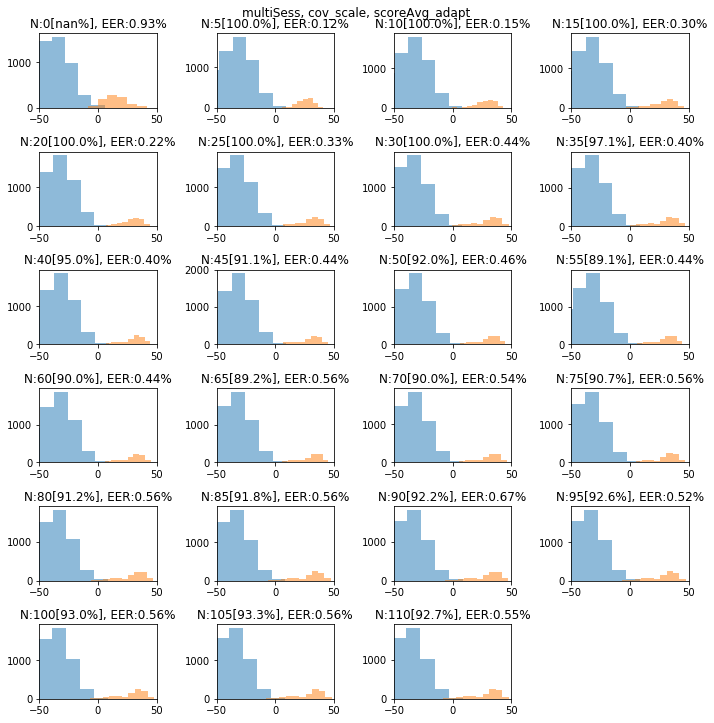

In [292]:
multiSess = dict()

for n_adapt in range(0, len(adapt_idx)+1, 5):
    adapted_embeds = adapt_embeds[adapt_idx[:n_adapt]]
    total_enr_embeds = np.concatenate([init_enr_embeds, adapted_embeds])
    multiSess[n_adapt] = py_plda_model.multi_sess(total_enr_embeds, test_embeds, 
                                         cov_scaling=True, cov_adapt=False).mean(0)

fig = plt.figure(figsize(10,10))
for i, (k, v) in enumerate(multiSess.items()):
    plt.subplot(np.ceil(len(multiSess)/4), 4, i+1)
    plt.xlim([-50, 50])
    plt.hist(v[test_trial[1]==0], alpha=0.5)
    plt.hist(v[test_trial[1]==1], alpha=0.5)
    eer = compute_eer(v, test_trial[1], verbose=False)[0]
    adapt_acc = np.mean(adapt_trial[1][adapt_idx[:k]])
    plt.title("N:{}[{:.1f}%], EER:{:.2f}%".format(k, adapt_acc*100, eer*100))
fig.suptitle("multiSess, cov_scale, scoreAvg_adapt", y=1.0)
plt.tight_layout()
plt.show()

In [ ]:
multiSess = dict()

for n_adapt in range(0, len(adapt_idx)+1, 2):
    adapted_embeds = adapt_embeds[adapt_idx[:n_adapt]]
    total_enr_embeds = np.concatenate([init_enr_embeds, adapted_embeds])
    multiSess[n_adapt] = py_plda_model.multi_sess(total_enr_embeds, test_embeds, 
                                         cov_scaling=False, cov_adapt=True).mean(0)
    
fig = plt.figure(figsize(10,10))
for i, (k, v) in enumerate(multiSess.items()):
    plt.subplot(np.ceil(len(multiSess)/4), 4, i+1)
    plt.xlim([-50, 50])
    plt.hist(v[test_trial[1]==0], alpha=0.5)
    plt.hist(v[test_trial[1]==1], alpha=0.5)
    eer = compute_eer(v, test_trial[1], verbose=False)[0]
    adapt_acc = np.mean(adapt_trial[1][adapt_idx[:k]])
    plt.title("N:{}[{:.1f}%], EER:{:.2f}%".format(k, adapt_acc*100, eer*100))
fig.suptitle("multiSess, cov_adapt", y=1.0)
plt.tight_layout()
plt.show()

In [ ]:
scoreAvg = dict()

adapted_embeds = adapt_embeds[adapt_idx]
total_enr_embeds = np.concatenate([init_enr_embeds, adapted_embeds])
scoreAvg_tot_scores = py_plda_model.score_avg(total_enr_embeds, test_embeds)

for n_adapt in range(0, len(total_enr_embeds)-3, 5):
    scoreAvg[n_adapt] = scoreAvg_tot_scores[:3+n_adapt].mean(0)
    
fig = plt.figure(figsize(10,10))
for i, (k, v) in enumerate(scoreAvg.items()):
    plt.subplot(np.ceil(len(scoreAvg)/4), 4, i+1)
    plt.xlim([-50, 50])
    plt.hist(v[test_trial[1]==0], alpha=0.5)
    plt.hist(v[test_trial[1]==1], alpha=0.5)
    eer = compute_eer(v, test_trial[1], verbose=False)[0]
    adapt_acc = np.mean(adapt_trial[1][adapt_idx[:k]])
    plt.title("N:{}[{:.1f}%], EER:{:.2f}%".format(k, adapt_acc*100, eer*100))
plt.tight_layout()
plt.show()

## Precision/Recall impact 

In [554]:
from tqdm import tqdm 

eT_list =  [-15, -10, -5, 0, 5, 10, 15]
# multiSess_scale = {k:[] for k in eT_list}
# multiSess_adapt = {k:[] for k in eT_list}
# adapt_preds = {k:[] for k in eT_list}

# multiSess_opt = []
# multiSess_init = []
# adapt_label_list = []
label_list = []
t_end = len(trials)
# t_end = 10
t_st = 1

for i, t_i in tqdm(enumerate(range(0, t_end, t_st)), total=t_end//t_st):
    enr_spk, enr_ids, test_trial = trials[t_i]
    test_trial = (np.array(test_trial.id), np.array(test_trial.label))

    adapt_len = 300
    adapt_trial = (test_trial[0][:adapt_len], test_trial[1][:adapt_len])
    test_trial = (test_trial[0][adapt_len:], test_trial[1][adapt_len:])
    label_list.append(test_trial[1])
    adapt_label_list.append(adapt_trial[1])
    
    init_enr_embeds = get_embeds(enr_ids, sv_embeds,  sv_id2idx, norm=False)
    adapt_embeds = get_embeds(adapt_trial[0], sv_embeds, sv_id2idx, norm=False)
    test_embeds = get_embeds(test_trial[0], sv_embeds, sv_id2idx, norm=False)
    
    adapt_scores = py_plda_model.score_avg(init_enr_embeds, adapt_embeds)
    
    optimal_enr_embeds = np.concatenate([init_enr_embeds, adapt_embeds[adapt_trial[1]==1]])
#     multiSess_opt.append(py_plda_model.multi_sess(optimal_enr_embeds, test_embeds,
#                                                  cov_scaling=True, cov_adapt=False).mean(0))
#     multiSess_init.append(py_plda_model.multi_sess(init_enr_embeds, test_embeds,
#                                                  cov_scaling=True, cov_adapt=False).mean(0))
    
#     for eT in eT_list:
#         # adaptation
#         adapted_embeds = adapt_embeds[adapt_scores.mean(0) > eT]
#         adapt_preds[eT].append(adapt_scores.mean(0) > eT)

#         # test
#         total_enr_embeds = np.concatenate([init_enr_embeds, adapted_embeds])
#         multiSess_scale[eT].append(py_plda_model.multi_sess(total_enr_embeds, test_embeds, 
#                                              cov_scaling=True, cov_adapt=False).mean(0))
#         multiSess_adapt[eT].append(py_plda_model.multi_sess(total_enr_embeds, test_embeds, 
#                                              cov_scaling=False, cov_adapt=True).mean(0))


100%|██████████| 622/622 [02:41<00:00,  3.84it/s]


In [543]:
np.concatenate(label_list).shape

(1849732,)

In [556]:
print("init")
compute_eer(np.concatenate(multiSess_init), np.concatenate(label_list))

init
eer: 6.97%, fpr: 6.97%, fnr: 6.97%


(0.06972727463937475, 0.06972727463937475, 0.06972396820360671, -14.322)

In [557]:
print("optimal")
compute_eer(np.concatenate(multiSess_opt), np.concatenate(label_list))

optimal
eer: 0.80%, fpr: 0.80%, fnr: 0.80%


(0.008028466475059047, 0.008028466475059047, 0.00802627404237799, -1.6263)

In [558]:
for eT in eT_list:
    precision, recall, _, _ = precision_recall_fscore_support(np.concatenate(adapt_label_list), np.concatenate(adapt_preds[eT]), average='binary')
    print("eT:{}, precision:{:.3f}, recall:{:.3f}".format(eT, precision, recall))
    compute_eer(np.concatenate(multiSess_scale[eT]), np.concatenate(label_list))
    compute_eer(np.concatenate(multiSess_adapt[eT]), np.concatenate(label_list))
    print()

ValueError: Found input variables with inconsistent numbers of samples: [563100, 186600]

In [514]:
t_idx = 3
eT = 5
precision, recall, _, _ = precision_recall_fscore_support(adapt_label_list[t_idx], adapt_preds[eT][t_idx], average='binary')
print("eT:{}, precision:{:.3f}, recall:{:.3f}".format(eT, precision, recall))

eT:5, precision:0.972, recall:0.875


In [507]:
eT = 15
eers = []
precisions = []
recalls = []
for t_idx in range(len(multiSess_scale[eT])):
    precision, recall, _, _ = precision_recall_fscore_support(adapt_label_list[t_idx], adapt_preds[eT][t_idx], average='binary')
    precisions.append(precision)
    recalls.append(recall)
    print("eT:{}, precision:{:.3f}, recall:{:.3f}".format(eT, precision, recall))
    eers.append(compute_eer(multiSess_scale[5][t_idx], label_list[t_idx])[0])
    print()

eT:15, precision:1.000, recall:0.207
eer: 0.00%, fpr: 0.00%, fnr: 0.00%

eT:15, precision:1.000, recall:0.214
eer: 0.21%, fpr: 0.21%, fnr: 0.00%

eT:15, precision:1.000, recall:0.268
eer: 0.00%, fpr: 0.00%, fnr: 0.00%

eT:15, precision:1.000, recall:0.500
eer: 0.30%, fpr: 0.30%, fnr: 0.00%

eT:15, precision:1.000, recall:0.093
eer: 0.48%, fpr: 0.42%, fnr: 0.48%

eT:15, precision:1.000, recall:0.152
eer: 0.97%, fpr: 0.92%, fnr: 0.97%

eT:15, precision:1.000, recall:0.316
eer: 1.10%, fpr: 1.10%, fnr: 0.88%

eT:15, precision:1.000, recall:0.500
eer: 0.91%, fpr: 0.00%, fnr: 0.91%

eT:15, precision:1.000, recall:0.857
eer: 0.06%, fpr: 0.06%, fnr: 0.00%

eT:15, precision:1.000, recall:0.750
eer: 0.00%, fpr: 0.00%, fnr: 0.00%

eT:15, precision:1.000, recall:0.649
eer: 0.00%, fpr: 0.00%, fnr: 0.00%

eT:15, precision:1.000, recall:1.000
eer: 0.18%, fpr: 0.00%, fnr: 0.18%

eT:15, precision:1.000, recall:0.975
eer: 0.00%, fpr: 0.00%, fnr: 0.00%

eT:15, precision:1.000, recall:0.622
eer: 0.00%, fp

/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


eer: 0.00%, fpr: 0.00%, fnr: 0.00%

eT:15, precision:1.000, recall:0.128
eer: 0.22%, fpr: 0.22%, fnr: 0.00%

eT:15, precision:1.000, recall:0.816
eer: 0.22%, fpr: 0.22%, fnr: 0.00%

eT:15, precision:1.000, recall:0.586
eer: 0.98%, fpr: 0.64%, fnr: 0.98%

eT:15, precision:1.000, recall:0.686
eer: 0.13%, fpr: 0.13%, fnr: 0.00%

eT:15, precision:1.000, recall:0.594
eer: 0.27%, fpr: 0.27%, fnr: 0.00%

eT:15, precision:1.000, recall:0.853
eer: 0.00%, fpr: 0.00%, fnr: 0.00%

eT:15, precision:1.000, recall:0.692
eer: 0.27%, fpr: 0.27%, fnr: 0.00%

eT:15, precision:1.000, recall:0.627
eer: 0.00%, fpr: 0.00%, fnr: 0.00%

eT:15, precision:1.000, recall:0.735
eer: 0.20%, fpr: 0.20%, fnr: 0.00%

eT:15, precision:1.000, recall:0.615
eer: 0.00%, fpr: 0.00%, fnr: 0.00%

eT:15, precision:1.000, recall:1.000
eer: 0.00%, fpr: 0.00%, fnr: 0.00%

eT:15, precision:1.000, recall:1.000
eer: 0.00%, fpr: 0.00%, fnr: 0.00%

eT:15, precision:1.000, recall:0.410
eer: 0.33%, fpr: 0.21%, fnr: 0.33%

eT:15, precisio

In [562]:
for t_idx in range(len(multiSess_init)):
    compute_eer(multiSess_init[t_idx], label_list[t_idx])
    

eer: 0.32%, fpr: 0.32%, fnr: 0.00%
eer: 3.88%, fpr: 3.87%, fnr: 3.88%
eer: 3.64%, fpr: 3.59%, fnr: 3.64%
eer: 8.11%, fpr: 7.80%, fnr: 8.11%
eer: 9.05%, fpr: 8.89%, fnr: 9.05%
eer: 8.21%, fpr: 8.03%, fnr: 8.21%
eer: 2.63%, fpr: 2.34%, fnr: 2.63%
eer: 0.91%, fpr: 0.82%, fnr: 0.91%
eer: 0.47%, fpr: 0.47%, fnr: 0.43%
eer: 0.43%, fpr: 0.29%, fnr: 0.43%
eer: 1.09%, fpr: 1.08%, fnr: 1.09%
eer: 0.73%, fpr: 0.73%, fnr: 0.71%
eer: 0.00%, fpr: 0.00%, fnr: 0.00%
eer: 2.44%, fpr: 2.44%, fnr: 2.42%
eer: 10.84%, fpr: 10.70%, fnr: 10.84%
eer: 6.05%, fpr: 6.05%, fnr: 5.73%
eer: 4.11%, fpr: 4.11%, fnr: 3.42%
eer: 4.60%, fpr: 4.60%, fnr: 4.17%
eer: 2.33%, fpr: 2.08%, fnr: 2.33%
eer: 1.90%, fpr: 1.79%, fnr: 1.90%
eer: 2.06%, fpr: 2.06%, fnr: 2.01%
eer: 11.97%, fpr: 11.92%, fnr: 11.97%
eer: 2.05%, fpr: 2.05%, fnr: 1.87%
eer: 5.71%, fpr: 5.39%, fnr: 5.71%
eer: 0.58%, fpr: 0.58%, fnr: 0.00%
eer: 1.36%, fpr: 1.36%, fnr: 1.24%
eer: 0.74%, fpr: 0.74%, fnr: 0.62%
eer: 1.29%, fpr: 1.29%, fnr: 1.25%
eer: 2.63%, fp

In [561]:
label_list[0]

array([0, 0, 0, ..., 0, 0, 1])

In [433]:
auc = roc_auc_score(adapt_trial[1], adapt_scores.mean(0))
ap = average_precision_score(adapt_trial[1], adapt_scores.mean(0))
print("AUC:{:.2f}, AP:{:.2f}".format(auc, ap))

AUC:1.00, AP:1.00


In [300]:
# F-norm

client_scores = py_plda_model.score_avg(init_enr_embeds, init_enr_embeds)
client_mean = np.triu(client_scores, 1).mean()

cohort_ids = np.load("trials/dev940_eval311/dev_cohort_ids.npy")
cohort_embeds = get_embeds(cohort_ids, sv_embeds, sv_id2idx, norm=False)
imp_scores = py_plda_model.score_avg(init_enr_embeds, cohort_embeds).mean(0)
imp_mean = imp_scores.mean()

a = 1
f_scores = (adapt_scores-imp_mean)*(2*a/(client_mean - imp_mean)) - a

In [319]:
adapt_eT = 10
f_adapt_preds = f_scores.mean(0) > 0.5
f_adapt_idx = np.nonzero(f_adapt_preds)[0]
adapt_preds = adapt_scores.mean(0) > adapt_eT
adapt_idx = np.nonzero(adapt_preds)[0]

### LR model score 

In [ ]:
tr_idx = 450
tr_score_avg = np.concatenate([s.mean(0) for s in scoreAvg[:tr_idx]])
tr_score_std = np.concatenate([s.std(0) for s in scoreAvg[:tr_idx]])
tr_score_max = np.concatenate([s.max(0) for s in scoreAvg[:tr_idx]])
tr_labels = np.concatenate(labels[:tr_idx])
tr_feat = np.stack([tr_score_avg, tr_score_std, tr_score_max], axis=1) 

te_score_avg = np.concatenate([s.mean(0) for s in scoreAvg[tr_idx:]])
te_score_std = np.concatenate([s.std(0) for s in scoreAvg[tr_idx:]])
te_score_max = np.concatenate([s.max(0) for s in scoreAvg[tr_idx:]])
te_labels = np.concatenate(labels[tr_idx:])
te_feat = np.stack([te_score_avg, te_score_std, te_score_max], axis=1) 

# LR train
from sklearn.linear_model import LogisticRegressionCV

lr_clf = LogisticRegressionCV(Cs=10, fit_intercept=True, class_weight='balanced')
lr_clf.fit(tr_feat, tr_labels)

In [ ]:
score_feat = lr_clf.decision_function(te_feat)
compute_eer(score_feat, te_labels);

In [ ]:
compute_eer(te_score_avg, te_labels);